In [1]:
#--Importing Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [2]:
#!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d prathumarikeri/indian-sign-language-isl

 97% 273M/281M [00:02<00:00, 90.9MB/s]
100% 281M/281M [00:02<00:00, 119MB/s] 


In [5]:
!unzip indian-sign-language-isl.zip

Streaming output truncated to the last 5000 lines.
  inflating: Indian/V/819.jpg        
  inflating: Indian/V/82.jpg         
  inflating: Indian/V/820.jpg        
  inflating: Indian/V/821.jpg        
  inflating: Indian/V/822.jpg        
  inflating: Indian/V/823.jpg        
  inflating: Indian/V/824.jpg        
  inflating: Indian/V/825.jpg        
  inflating: Indian/V/826.jpg        
  inflating: Indian/V/827.jpg        
  inflating: Indian/V/828.jpg        
  inflating: Indian/V/829.jpg        
  inflating: Indian/V/83.jpg         
  inflating: Indian/V/830.jpg        
  inflating: Indian/V/831.jpg        
  inflating: Indian/V/832.jpg        
  inflating: Indian/V/833.jpg        
  inflating: Indian/V/834.jpg        
  inflating: Indian/V/835.jpg        
  inflating: Indian/V/836.jpg        
  inflating: Indian/V/837.jpg        
  inflating: Indian/V/838.jpg        
  inflating: Indian/V/839.jpg        
  inflating: Indian/V/84.jpg         
  inflating: Indian/V/840.jpg        

In [6]:
#--Creating Data Frame for better manipulation
root_dir = '/content/Indian/'

image_data = []
labels = [str(i) for i in range(1, 10)] + [chr(ord('A') + i) for i in range(26)]


for label in labels:
    label_dir = os.path.join(root_dir, label)
    for image_file in os.listdir(label_dir):
        image = Image.open(os.path.join(label_dir, image_file))
        image_data.append({
            'label': label,
            'color_image': image
        })

df = pd.DataFrame(image_data)

In [7]:
df.head()

,label,color_image
0,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...


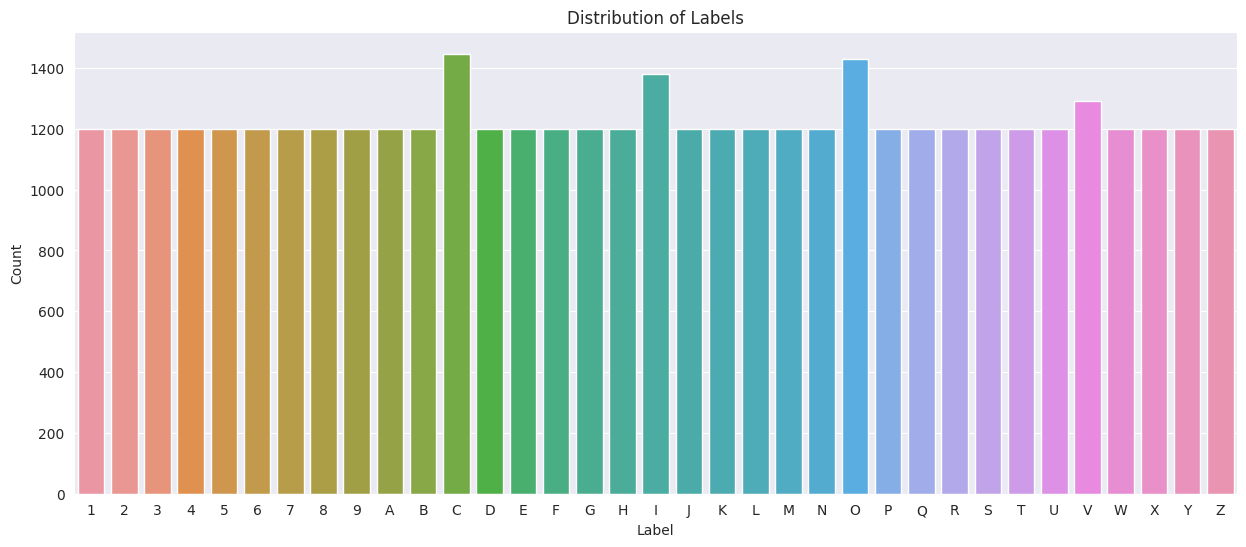

In [8]:
#--Visualizing value counts
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.countplot(data=df,x='label')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

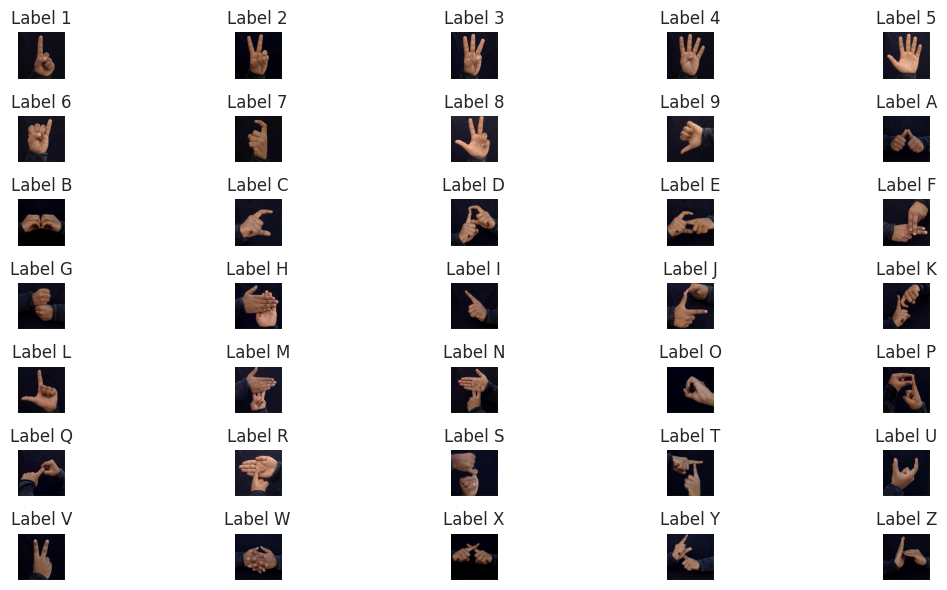

In [9]:
#--Visualizing categories in the dataset
fig, axs = plt.subplots(7, 5, figsize=(12, 6))

for i, (label, image) in enumerate(df.groupby('label').first().reset_index()[['label', 'color_image']].itertuples(index=False)):
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title('Label {}'.format(label))
    ax.axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Preprocessing steps
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['label'])
images = np.array(df['color_image'].tolist())
#label = np.array(df['encoded_labels'].tolist())

<ipython-input-10-c81b23568f05>:5: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  images = np.array(df['color_image'].tolist())
<ipython-input-10-c81b23568f05>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(df['color_image'].tolist())


In [11]:
# Resize images to desired dimensions
resized_images = []
for image in df['color_image']:
    resized_image = image.resize((32, 32))  # Resize the image to the desired size
    resized_images.append(np.array(resized_image))
images = np.array(resized_images)

In [12]:
df['label'].value_counts()[:10]

C    1447
O    1429
I    1379
V    1290
Q    1200
L    1200
M    1200
N    1200
P    1200
R    1200
Name: label, dtype: int64

In [13]:
df['encoded_labels'].shape

(42745,)

In [14]:
images.shape

(42745, 32, 32, 3)

In [15]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, df['encoded_labels'], test_size=0.2, random_state=0)

In [16]:
y_train.shape

(34196,)

In [17]:
#--Converting to float
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [18]:
#--For dealing with shape error encountered in modeling process
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
#--Imporing Modeling libraries
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout


In [20]:
#Initialising vgg16
vgg16_architecture = VGG16(input_shape= (32,32,3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
#Don't train existing weights for vgg16
for layer in vgg16_architecture.layers:
    layer.trainable = False

In [22]:
model_1 = vgg16_architecture.output
model_1 = Flatten()(model_1)
model_1 = Dense(units=256, activation='relu')(model_1)
model_1 = Dropout(0.6)(model_1)
model_1 = Dense(35, activation='softmax')(model_1)


vgg_model = Model(inputs = vgg16_architecture.input , outputs = model_1)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = vgg_model.fit(X_train, y_train, epochs = 30, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/30
535/535 [==============================] - 21s 19ms/step - loss: 0.5707 - accuracy: 0.8949 - val_loss: 0.0113 - val_accuracy: 0.9999
Epoch 2/30
535/535 [==============================] - 9s 16ms/step - loss: 0.0296 - accuracy: 0.9978 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/30
535/535 [==============================] - 10s 18ms/step - loss: 0.0115 - accuracy: 0.9996 - val_loss: 5.5247e-04 - val_accuracy: 1.0000
Epoch 4/30
535/535 [==============================] - 7s 13ms/step - loss: 0.0065 - accuracy: 0.9997 - val_loss: 2.4263e-04 - val_accuracy: 1.0000
Epoch 5/30
535/535 [==============================] - 7s 14ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 1.0502e-04 - val_accuracy: 1.0000
Epoch 6/30
535/535 [==============================] - 7s 14ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 1.2363e-04 - val_accuracy: 1.0000
Epoch 7/30
535/535 [==============================] - 7s 13ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 3.5183e-05 

In [24]:
score =vgg_model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %


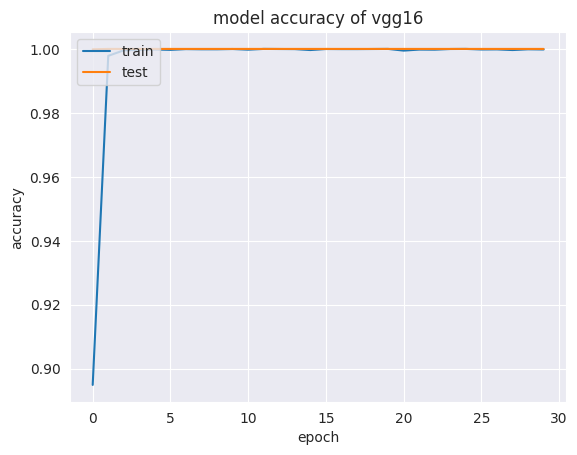

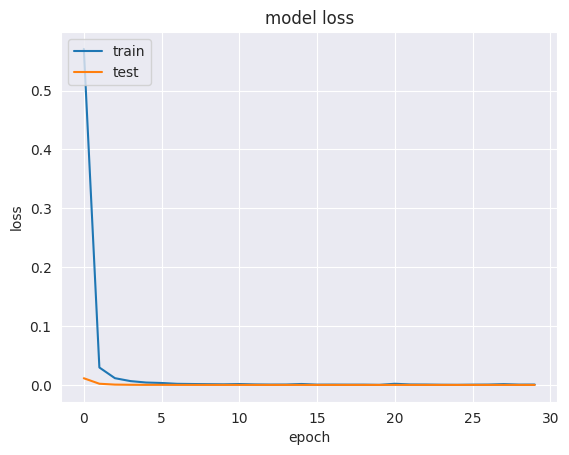

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()